# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

time: 11 s (started: 2023-02-28 18:16:22 +09:00)


In [3]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    #return result # testing
        
    #if np.isnan(result['history']['win_rate'].squeeze()):
    if result['history']['total'].squeeze() == 0:
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n}% done')
        return n
    else:
        return last_print

time: 7.66 ms (started: 2023-02-28 18:16:33 +09:00)


In [4]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 287 ms (started: 2023-02-28 18:16:46 +09:00)


In [5]:
df_compare = pd.DataFrame()

time: 1.54 ms (started: 2023-02-28 18:16:56 +09:00)


# Buy & hold

## Settings

In [6]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 12.9 ms (started: 2023-02-28 18:17:02 +09:00)


In [7]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 7.63 ms (started: 2023-02-28 18:17:05 +09:00)


In [8]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 7.12 ms (started: 2023-02-28 18:17:07 +09:00)


In [9]:
# testing
#dates_start = dates_start[:50]

time: 6.51 ms (started: 2023-02-23 12:18:50 +09:00)


## SC01

In [10]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1e+03 µs (started: 2023-02-23 12:18:51 +09:00)


In [11]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 6s (started: 2023-02-23 12:18:52 +09:00)


In [12]:
df_result['return'].agg(['mean','min','max'])

mean      6.723509
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 19.3 ms (started: 2023-02-23 12:31:58 +09:00)


In [13]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 10.9 ms (started: 2023-02-23 12:31:58 +09:00)


## SC02

In [14]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 7.29 ms (started: 2023-02-23 12:32:42 +09:00)


In [15]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 14min (started: 2023-02-23 12:32:45 +09:00)


In [16]:
df_result['return'].agg(['mean','min','max'])

mean     2.625810
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 21.3 ms (started: 2023-02-23 12:46:46 +09:00)


In [17]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22.4 ms (started: 2023-02-23 12:46:46 +09:00)


## SC03

In [18]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.06 ms (started: 2023-02-23 12:46:46 +09:00)


In [19]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 15min 10s (started: 2023-02-23 12:46:46 +09:00)


In [20]:
df_result['return'].agg(['mean','min','max'])

mean     2.453650
min    -16.298809
max     36.055343
Name: return, dtype: float64

time: 21 ms (started: 2023-02-23 13:01:56 +09:00)


In [21]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 18.3 ms (started: 2023-02-23 13:01:56 +09:00)


## Compare

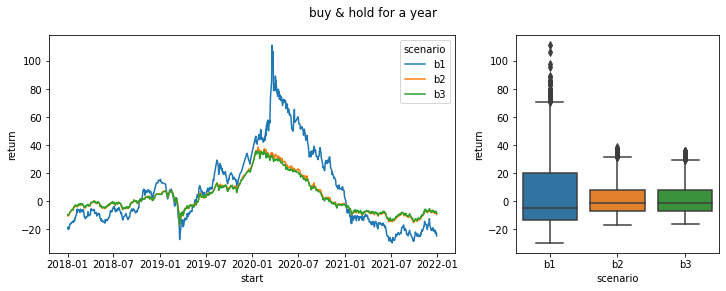

time: 1.35 s (started: 2023-02-23 13:01:56 +09:00)


In [23]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

df = df_compare.dropna(subset='return').reset_index()
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

# Technical Indicator

## Settings

In [213]:
import tulipy as ti

time: 22.8 ms (started: 2023-02-28 13:52:16 +09:00)


In [214]:
def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 3.58 ms (started: 2023-02-28 13:52:16 +09:00)


In [75]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 12.9 ms (started: 2023-02-23 14:48:52 +09:00)


In [76]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 3.03 ms (started: 2023-02-23 14:48:53 +09:00)


In [31]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.08 ms (started: 2023-02-23 13:02:54 +09:00)


In [32]:
# testing
#dates_start = dates_start[400:500]

time: 642 µs (started: 2023-02-23 13:02:55 +09:00)


## SC01: MACD

### calc tech indi

In [78]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 10.6 ms (started: 2023-02-23 14:49:23 +09:00)


In [34]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 11.8 ms (started: 2023-02-23 13:02:57 +09:00)


In [35]:
df_bt = finish_custom(df_bt)

time: 373 ms (started: 2023-02-23 13:02:58 +09:00)


In [36]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1161
 1      38
-1      33
Name: custom, dtype: int64

time: 10.4 ms (started: 2023-02-23 13:02:58 +09:00)


### bactesting 1

In [37]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 990 µs (started: 2023-02-23 13:03:02 +09:00)


In [39]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
255: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
40 scenarios of no buy.
time: 16min 39s (started: 2023-02-23 13:03:52 +09:00)


In [40]:
df_result['return'].agg(['mean','min','max'])

mean     7.291352
min    -12.013608
max     57.532363
Name: return, dtype: float64

time: 14.3 ms (started: 2023-02-23 13:20:32 +09:00)


In [41]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.4 ms (started: 2023-02-23 13:20:32 +09:00)


### bactesting 2

In [42]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.01 ms (started: 2023-02-23 13:20:32 +09:00)


In [43]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
258: No buy at all
30 % done
there are more scenarios of no buy.
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
33 scenarios of no buy.
time: 18min 49s (started: 2023-02-23 13:20:32 +09:00)


In [44]:
df_result['return'].agg(['mean','min','max'])

mean     4.238674
min     -6.153420
max     36.403294
Name: return, dtype: float64

time: 14.5 ms (started: 2023-02-23 13:39:21 +09:00)


In [45]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.7 ms (started: 2023-02-23 13:39:21 +09:00)


### bactesting 3

In [46]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.15 ms (started: 2023-02-23 13:39:21 +09:00)


In [47]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
213: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
25 scenarios of no buy.
time: 21min 46s (started: 2023-02-23 13:39:21 +09:00)


In [48]:
df_result['return'].agg(['mean','min','max'])

mean     1.731516
min     -3.162596
max     16.136710
Name: return, dtype: float64

time: 15.9 ms (started: 2023-02-23 14:01:08 +09:00)


In [49]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 12.3 ms (started: 2023-02-23 14:01:08 +09:00)


### bactesting 4

In [60]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 1.21 ms (started: 2023-02-23 14:14:27 +09:00)


In [61]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

36: No buy at all
10 % done
20 % done
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
42 scenarios of no buy.
time: 25min 38s (started: 2023-02-23 14:14:29 +09:00)


In [62]:
df_result['return'].agg(['mean','min','max'])

mean     6.535910
min    -18.098724
max     68.160862
Name: return, dtype: float64

time: 14.9 ms (started: 2023-02-23 14:40:08 +09:00)


In [63]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 16.4 ms (started: 2023-02-23 14:40:08 +09:00)


In [74]:
#df_compare.to_csv('df_compare1.csv')

time: 224 ms (started: 2023-02-23 14:47:22 +09:00)


### compare

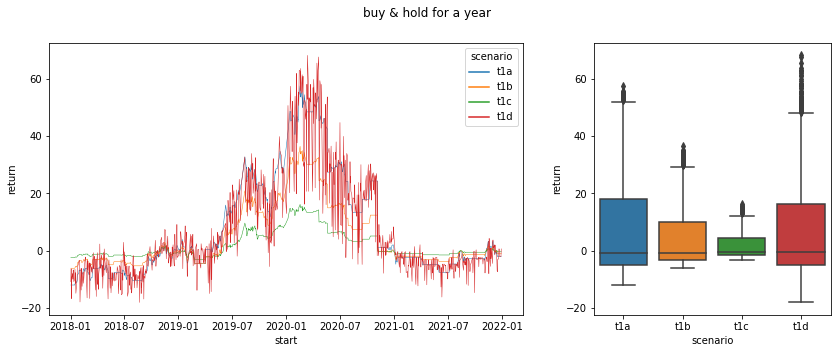

time: 1.39 s (started: 2023-02-23 17:23:01 +09:00)


In [105]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t1')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC02: Bollinger Bands

### calc tech indi

In [79]:
df_bt = df_bt_ori.copy()
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 5.56 ms (started: 2023-02-23 14:49:34 +09:00)


In [80]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 8.15 ms (started: 2023-02-23 14:49:40 +09:00)


In [81]:
df_bt = finish_custom(df_bt)

time: 193 ms (started: 2023-02-23 14:49:42 +09:00)


In [82]:
df_bt.custom.value_counts()

 0    1157
-1      42
 1      33
Name: custom, dtype: int64

time: 18.3 ms (started: 2023-02-23 14:49:44 +09:00)


### bactesting 1

In [83]:
scenario = 't2a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 5.57 ms (started: 2023-02-23 14:50:05 +09:00)


In [84]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
72 scenarios of no buy.
time: 29min 5s (started: 2023-02-23 14:50:07 +09:00)


In [85]:
df_result['return'].agg(['mean','min','max'])

mean    -2.072691
min    -25.756412
max     19.857751
Name: return, dtype: float64

time: 15.5 ms (started: 2023-02-23 15:19:12 +09:00)


In [86]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-23 15:19:12 +09:00)


### bactesting 2

In [87]:
scenario = 't2b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.03 ms (started: 2023-02-23 15:19:12 +09:00)


In [88]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
79 scenarios of no buy.
time: 33min 50s (started: 2023-02-23 15:19:13 +09:00)


In [89]:
df_result['return'].agg(['mean','min','max'])

mean    -2.049049
min    -24.544178
max     13.797432
Name: return, dtype: float64

time: 12.8 ms (started: 2023-02-23 15:53:03 +09:00)


In [90]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.9 ms (started: 2023-02-23 15:53:03 +09:00)


### bactesting 3

In [91]:
scenario = 't2c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.02 ms (started: 2023-02-23 15:53:03 +09:00)


In [92]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

62: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
111 scenarios of no buy.
time: 38min 46s (started: 2023-02-23 15:53:04 +09:00)


In [93]:
df_result['return'].agg(['mean','min','max'])

mean    -1.976350
min    -20.921568
max      6.320392
Name: return, dtype: float64

time: 18.8 ms (started: 2023-02-23 16:31:50 +09:00)


In [94]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22 ms (started: 2023-02-23 16:31:50 +09:00)


### bactesting 4

In [95]:
scenario = 't2d'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

proba = 0.5

time: 1.14 ms (started: 2023-02-23 16:31:50 +09:00)


In [96]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

17: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
133 scenarios of no buy.
time: 45min (started: 2023-02-23 16:31:51 +09:00)


In [97]:
df_result['return'].agg(['mean','min','max'])

mean    -1.766146
min    -17.846510
max     10.629953
Name: return, dtype: float64

time: 19.8 ms (started: 2023-02-23 17:16:51 +09:00)


In [98]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 28.1 ms (started: 2023-02-23 17:16:51 +09:00)


In [99]:
#df_compare.to_csv('df_compare1.csv')

time: 392 ms (started: 2023-02-23 17:17:40 +09:00)


### compare

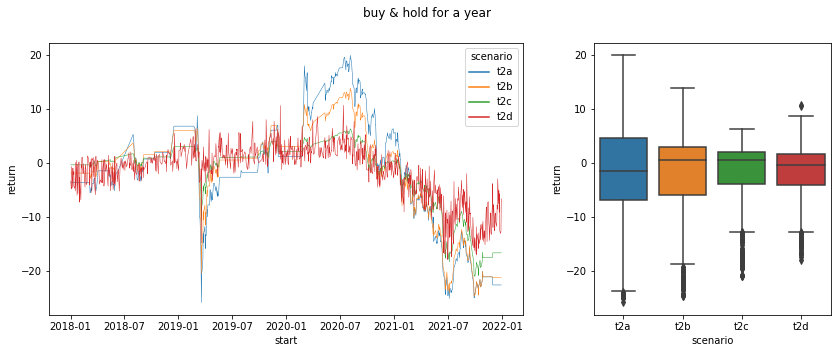

time: 1.36 s (started: 2023-02-23 17:21:49 +09:00)


In [104]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t2')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC03: Bollinger Bands & MACD

### calc tech indi

In [106]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])
df_bbands = calc_bbands(df_bt['close'])

time: 11.1 ms (started: 2023-02-23 17:24:38 +09:00)


In [107]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 14 ms (started: 2023-02-23 17:25:23 +09:00)


In [108]:
df_bt = finish_custom(df_bt)

time: 528 ms (started: 2023-02-23 17:25:29 +09:00)


In [109]:
df_bt.custom.value_counts()

 0    1207
 1      13
-1      12
Name: custom, dtype: int64

time: 20.7 ms (started: 2023-02-23 17:25:30 +09:00)


### bactesting

In [111]:
scenario = 't3'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.06 ms (started: 2023-02-23 17:26:47 +09:00)


In [112]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

26: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
501 scenarios of no buy.
time: 51min 12s (started: 2023-02-23 17:26:51 +09:00)


In [113]:
df_result['return'].agg(['mean','min','max'])

mean    1.768180
min    -1.706558
max     5.116971
Name: return, dtype: float64

time: 45 ms (started: 2023-02-23 18:18:03 +09:00)


In [114]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 478 ms (started: 2023-02-23 18:18:03 +09:00)


In [144]:
df_compare.to_csv('df_compare1.csv')

time: 346 ms (started: 2023-02-23 18:50:56 +09:00)


# Comparison

In [249]:
df_compare = pd.read_csv('df_compare1.csv', index_col=0, parse_dates=['start'])
#df_compare

time: 38.2 ms (started: 2023-02-28 14:33:11 +09:00)


In [250]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        6.723509 -4.410756 -29.578320  111.056006  27.760491   931
b2        2.625810 -1.313716 -16.512425   38.402674  12.987301   923
b3        2.453650 -1.279150 -16.298809   36.055343  12.294943   921
t1a       7.291352 -0.666501 -12.013608   57.532364  17.581918   945
t1b       4.238674 -1.001026  -6.153420   36.403294  10.546404   952
t1c       1.731516 -0.565984  -3.162596   16.136710   4.682957   960
t1d       6.535910 -0.562195 -18.098724   68.160862  17.759968   943
t2a      -2.072691 -1.465398 -25.756412   19.857751  10.555794   913
t2b      -2.049049  0.534407 -24.544178   13.797432   9.210288   906
t2c      -1.976350  0.478720 -20.921568    6.320392   6.583703   874
t2d      -1.766146 -0.392498 -17.846510   10.629953   5.054592   852
t3        1.768180  1.218663  -1.706558    5.116971   2.173672   484

time: 56.9 ms (started: 2023-02-28 14:33:12 +09:00)


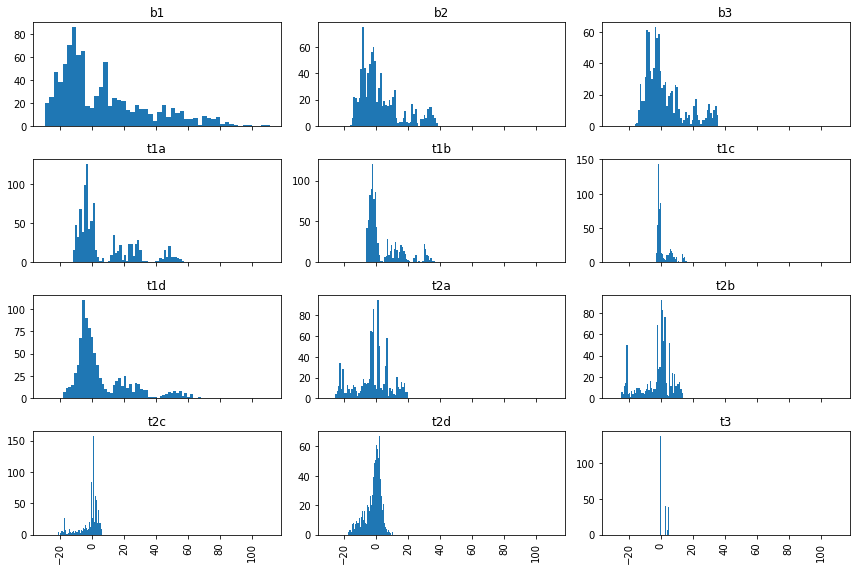

time: 7.31 s (started: 2023-02-27 22:33:42 +09:00)


In [10]:
_ = df_compare.hist(by='scenario', column='return', figsize=(12,8), bins=50, sharex=True)
plt.tight_layout()

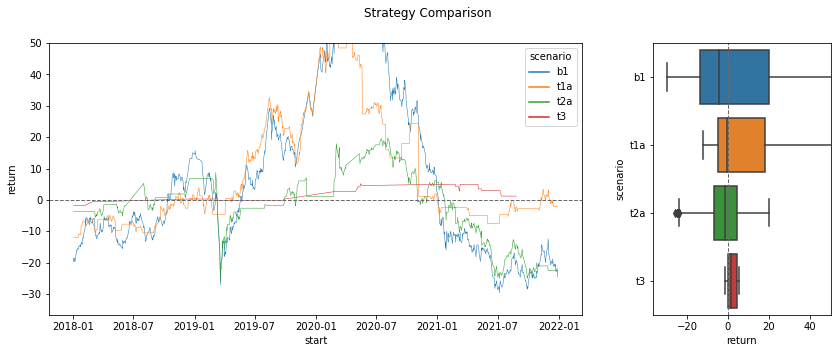

time: 1.46 s (started: 2023-02-23 20:27:31 +09:00)


In [165]:
ret_limit = 50
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      #.loc[df_compare.scenario.str.startswith('t2')]
      .loc[df_compare.scenario.isin(['b1', 't1a', 't2a', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

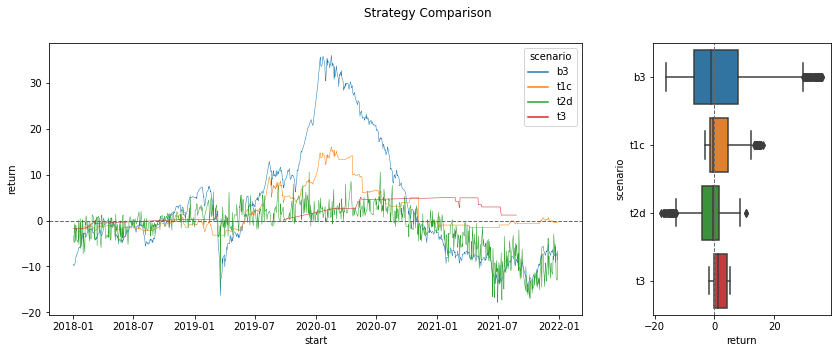

time: 1.42 s (started: 2023-02-23 20:58:09 +09:00)


In [167]:
ret_limit = None
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      .loc[df_compare.scenario.isin(['b3', 't1c', 't2d', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

## Bayesian estimation

### Settings

In [198]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from matplotlib.lines import Line2D
from scipy import stats

YEAR = 252
midx = pd.IndexSlice
DATE_FILE = '%y%m%d'


    
def bayesian_estimate(df_returns, draws=10000, tune=2500, burnin=0,
                      chains=4, target_accept=.9, inspect_mode=False, 
                      figsize=(10, 14), loc_legend='upper right',
                      plot_trace=True, save_plot=False, save_path=None):
    """
    Bayesian hypothesis test to compare two return distributions. 
    Returns are assumed to be T-distributed.
    can run with more than 2 return dists but no comparison then
    """
    if not isinstance(df_returns, pd.Series):
        print('ERROR: df_returns is not series')
        return
    else:
        df_returns = df_returns.dropna()
        lvl1, _ = df_returns.index.names
        
    # priors
    mean_prior, std_prior = df_returns.mean(), df_returns.std()
    std_low, std_high = std_prior / 1000, std_prior * 1000
    T = YEAR ** .5
    mean, std, returns = {}, {}, {}
    groups = df_returns.index.get_level_values(lvl1).unique()
    num_groups = len(groups) # flag to plot comparisio if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        for i, g in enumerate(groups):
            df_g = df_returns.loc[midx[g]]
            mean[i] = pm.Normal(f'mean_{g}', mu=mean_prior, sd=std_prior, testval=df_g.mean())
            std[i] = pm.Uniform(f'std_{g}', lower=std_low, upper=std_high, testval=df_g.std())
            returns[i] = pm.StudentT(f'returns_{g}', nu=nu, mu=mean[i], sd=std[i], observed=df_g)
            pm.Deterministic(f'vol_{g}', returns[i].distribution.sd * T)
            pm.Deterministic(f'sharpe_{g}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        if num_groups == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

    if inspect_mode:
        pm.model_to_graphviz(model=model)

    with model:
        # HMC NUTS Sampling
        #cores, _ = print_machine_type()
        trace = pm.sample(draws=draws, tune=tune,
                          chains=chains, 
                          #cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)
    #pm.trace_to_dataframe(trace).info()


    ### plot & compare
    # To compare the performance of two return series, we model each group’s Sharpe ratio separately 
    # and compute the effect size as the difference between the volatility-adjusted returns.
    plot_bayesian_returns(trace, groups, burnin, figsize, loc_legend, 
                                 save_plot, save_path)

    # TODO: implement
    #arviz.plot_forest(data=trace)

    if plot_trace:
        plot_traces(trace, burnin=burnin, fig_width=figsize[0])
        
    #return (trace, groups) # testing


def plot_bayesian_returns(trace, groups, 
                            burnin=0, figsize=(12, 16), loc_legend='upper right',
                            save=True, path=None):
    trace = trace[burnin:]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    num_groups = len(groups)
    if num_groups == 2:
        cols = 2
    else:
        cols = 1
    gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
    axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
    axs.append(plt.subplot(gs[3, :]))
    vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}
    
    kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
                   alpha=.4, edgecolor=(1, 1, 1, .4))

    def distplot_w_perc(trace, ax, p=2.5):
        sns.histplot(trace, ax=ax, **kw_hist)
        ps = [stats.scoreatpercentile(trace, x) for x in [p, 100-p]]
        ax.axvline(ps[0], **vl_style)
        ax.axvline(ps[1], **vl_style)
        line = Line2D([0,1],[0,1], **vl_style)
        ax.legend([line], ['2.5 & 97.5\npercentiles'],
                  loc=loc_legend, 
                  #frameon=True, framealpha=0.5
                 )
        display_credible(trace, ax, ref=0, alen=0.2*(ps[1]-ps[0]))

    def display_credible(trace, ax, ref=0, alen=1):
        if trace.min() < ref < trace.max():
            c = 'mediumblue'
            ax.axvline(ref,  lw=0.5, c=c)
            x = stats.percentileofscore(trace, ref)
            if x < 50:
                x = 100 - x
                ha = 'left'
            else:
                ha = 'right'
                alen = -alen
            a = np.mean(ax.get_ylim())
            ax.annotate(f'{x:.0f}%', 
                          xy=(ref, a), 
                          xycoords='data', 
                          xytext=(ref+alen, a), 
                          textcoords='data', 
                          ha=ha, 
                          va='center',
                          fontsize='large', 
                          color=c,
                          arrowprops=dict(edgecolor=c, width=20, headwidth=30, alpha=0.5)
                       )

    vs = ['mean', 'vol', 'sharpe']
    vsl = ['Mean', 'Annual volatility', 'Sharpe ratio']
    for i, v in enumerate(vs):
        dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
        sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[i*num_groups], **kw_hist)
        axs[i*num_groups].set(xlabel=vsl[i], ylabel='Belief', yticklabels=[])

    if num_groups == 2:
        distplot_w_perc(trace['mean diff'], axs[1])
        distplot_w_perc(trace[f'vol_{groups[0]}'] - trace[f'vol_{groups[1]}'], axs[3])
        distplot_w_perc(trace[f'sharpe_{groups[0]}'] - trace[f'sharpe_{groups[1]}'], axs[5]) 
        distplot_w_perc(trace['effect size'], axs[6])

        axs[1].set(xlabel='Difference of means', yticklabels=[])
        axs[3].set(xlabel='Difference of volatility', yticklabels=[])
        axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])
        axs[6].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
    sns.despine()
    fig.tight_layout()
    
    if save:
        dt = datetime.today().strftime(DATE_FILE)
        file = f'bayesian_returns2_{dt}.png'
        path = get_path(path)
        file = check_file_name(file, path)
        plt.savefig(path / file) # save as png type
        print(f'{file} saved.')


def plot_traces(traces, burnin=0, fig_width=12, height_unit=1.8):
    """ 
    Plot traces with overlaid means and values
    """
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(fig_width, len(traces.varnames)*height_unit),
                      lines=summary)
    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

time: 10.9 ms (started: 2023-02-28 12:52:13 +09:00)


### CS01

In [42]:
df = df_compare.loc[df_compare.scenario.isin(['b1','b2'])].reset_index().set_index(['scenario', 'start']).squeeze().dropna()

time: 13.4 ms (started: 2023-02-28 08:51:54 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 458 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


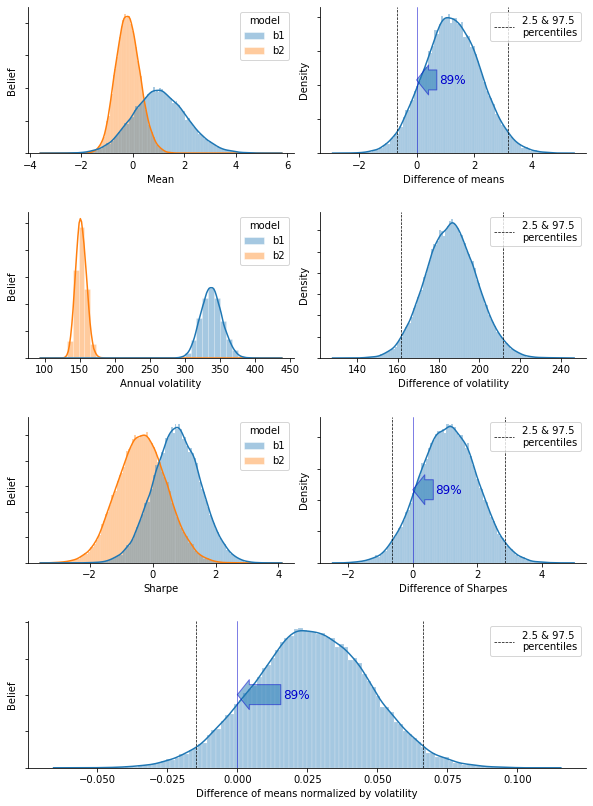

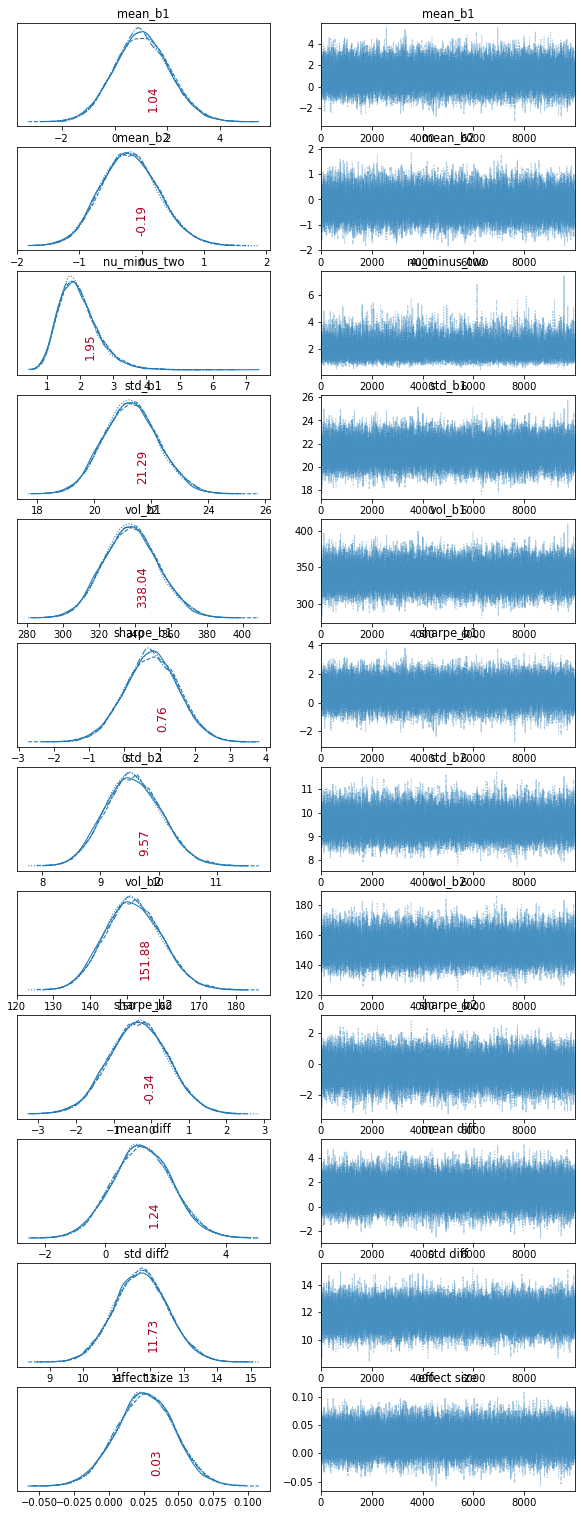

time: 10min 46s (started: 2023-02-28 12:20:47 +09:00)


In [194]:
bayesian_estimate(df)

### CS02

In [195]:
df = df_compare.loc[df_compare.scenario.isin(['b1','t1a'])].reset_index().set_index(['scenario', 'start']).squeeze()

time: 28.9 ms (started: 2023-02-28 12:31:34 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 587 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


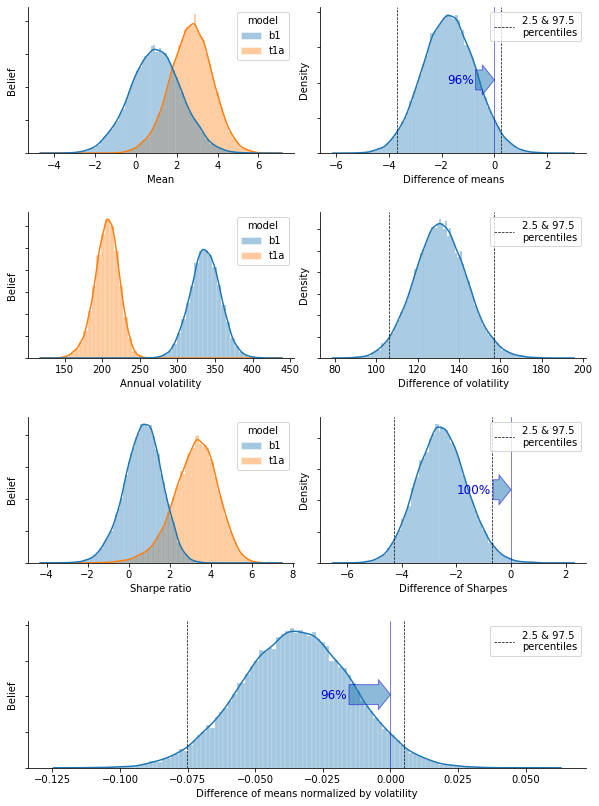

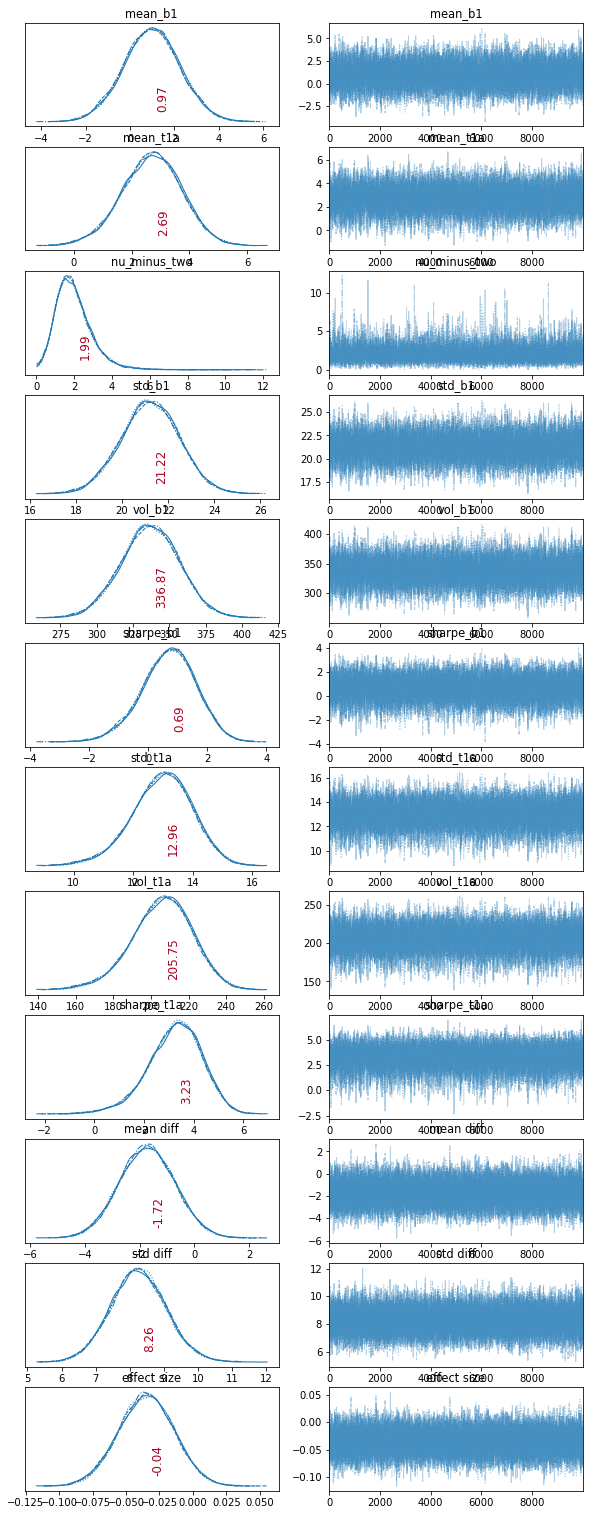

time: 13min (started: 2023-02-28 12:55:47 +09:00)


In [200]:
bayesian_estimate(df)

# Longer Data Period

## Settings

In [372]:
#start = '20130101'
#end = '20181231'
start = '20030101'
end = '20131231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 284 ms (started: 2023-02-28 18:06:35 +09:00)


In [373]:
#df_compare2 = pd.DataFrame()
df_compare3 = pd.DataFrame()

time: 6.23 ms (started: 2023-02-28 18:06:42 +09:00)


In [374]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 11.1 ms (started: 2023-02-28 18:06:43 +09:00)


In [375]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 9.18 ms (started: 2023-02-28 18:06:45 +09:00)


In [376]:
dates_start

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2012-12-13', '2012-12-14', '2012-12-17', '2012-12-18',
               '2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28'],
              dtype='datetime64[ns]', name='dt', length=2486, freq=None)

time: 17.7 ms (started: 2023-02-28 18:06:47 +09:00)


In [377]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 5.68 ms (started: 2023-02-28 18:06:50 +09:00)


## Buy & Hold

In [378]:
df_bt = df_bt_ori.copy()

time: 5.89 ms (started: 2023-02-28 18:06:52 +09:00)


In [379]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.17 ms (started: 2023-02-28 18:06:53 +09:00)


In [316]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 54min 11s (started: 2023-02-28 15:45:35 +09:00)


In [383]:
start = dates_start[0]
df_bt['custom'] = 0 # reset
df_bt.loc[start,'custom'] = -1
r = run_backtest(start, df_bt, kwargs_bt)
r

[Timestamp('2003-01-02 00:00:00'),
 Timestamp('2004-01-02 00:00:00'),
 -1,
 None,
 None]

time: 2.24 s (started: 2023-02-28 18:08:18 +09:00)


In [384]:
#def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
kwargs = kwargs_bt
proba=1
strategy='custom'
df = df_bt.copy()
end = start + timedelta(hold_period)
df = df.loc[start:end]
if proba < 1:
    df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
df = {symbol: df}
with HiddenPrints(mark_end=False):
    result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
#return result # testing

time: 2.05 s (started: 2023-02-28 18:11:21 +09:00)


In [ ]:
#if np.isnan(result['history']['win_rate'].squeeze()):
if result['history']['len'].squeeze() == 0:
    #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
    return [start, end, -1, None, None]
else:
    return [start, end] + result['summary']

In [400]:
#result['summary']
i = 4
result['history'].iloc[:, 10*i:10*(i+1)]

,,,won_max_prcnt,lost_max,lost_max_prcnt
start_date,end_date,symbol,,,
2003-01-02,2004-01-02,069500,NaN,NaN,NaN


time: 25.2 ms (started: 2023-02-28 18:15:37 +09:00)


In [398]:
result['history']['max'].squeeze()

AutoOrderedDict([('len', 108),
                 ('drawdown', 20.990389364467024),
                 ('moneydown', 2209548.0)])

time: 8.4 ms (started: 2023-02-28 18:15:09 +09:00)


In [393]:
result['summary']

[10000000.0, 13703360.576695416, 37.033605800000004]

time: 7.73 ms (started: 2023-02-28 18:14:04 +09:00)


In [317]:
df_result['return'].agg(['mean','min','max'])

mean    14.190377
min    -51.270513
max     80.280904
Name: return, dtype: float64

time: 24.3 ms (started: 2023-02-28 16:39:47 +09:00)


In [318]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
#df_compare2 = pd.concat([df_compare2, df]) 
df_compare3 = pd.concat([df_compare3, df]) 

time: 23.2 ms (started: 2023-02-28 16:39:47 +09:00)


## MACD

In [319]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 13.1 ms (started: 2023-02-28 16:39:48 +09:00)


In [320]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 19.7 ms (started: 2023-02-28 16:39:48 +09:00)


In [321]:
df_bt = finish_custom(df_bt)

time: 851 ms (started: 2023-02-28 16:39:48 +09:00)


In [322]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    2578
-1      91
 1      64
Name: custom, dtype: int64

time: 24.9 ms (started: 2023-02-28 16:39:48 +09:00)


In [323]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.12 ms (started: 2023-02-28 16:39:49 +09:00)


In [324]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

0: No buy at all
there are more scenarios of no buy.
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
180 scenarios of no buy.
time: 1h 17min 34s (started: 2023-02-28 16:39:49 +09:00)


In [325]:
df_result['return'].agg(['mean','min','max'])

mean     9.060399
min    -20.464112
max     48.476804
Name: return, dtype: float64

time: 30.5 ms (started: 2023-02-28 17:57:23 +09:00)


In [326]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
#df_compare2 = pd.concat([df_compare2, df]) 
df_compare3 = pd.concat([df_compare3, df]) 

time: 19.7 ms (started: 2023-02-28 17:57:24 +09:00)


In [327]:
#df_compare2.to_csv('df_compare2.csv')
df_compare3.to_csv('df_compare3.csv')

time: 193 ms (started: 2023-02-28 17:57:24 +09:00)


## Comparison

In [355]:
df_compare1 = pd.read_csv('df_compare1.csv', parse_dates=['start'])
df_compare2 = pd.read_csv('df_compare2.csv', parse_dates=['start'])
df_compare3 = pd.read_csv('df_compare3.csv', parse_dates=['start'])
df_compare = (pd.concat([df_compare3, df_compare2, df_compare1])
                .drop_duplicates(subset=['scenario','start'])
             )

time: 64.7 ms (started: 2023-02-28 18:00:51 +09:00)


In [356]:
df = df_compare.groupby('scenario')['start'].agg(['min','max','count'])
df

,min,max,count
scenario,,,
b1,2003-01-02,2021-12-29,4700
b2,2018-01-02,2021-12-29,985
b3,2018-01-02,2021-12-29,985
t1a,2003-01-02,2021-12-29,4700
t1b,2018-01-02,2021-12-29,985
t1c,2018-01-02,2021-12-29,985
t1d,2018-01-02,2021-12-29,985
t2a,2018-01-02,2021-12-29,985
t2b,2018-01-02,2021-12-29,985


time: 31.2 ms (started: 2023-02-28 18:00:53 +09:00)


In [368]:
df = df_compare3
df[df.scenario.str.startswith('b')]['return'].isna().sum()

247

time: 24.2 ms (started: 2023-02-28 18:03:55 +09:00)


In [370]:
df_compare3

,start,return,scenario
0,2003-01-02,NaN,b1
1,2003-01-03,NaN,b1
2,2003-01-06,NaN,b1
3,2003-01-07,NaN,b1
4,2003-01-08,NaN,b1
...,...,...,...
4967,2012-12-21,-2.919985,t1a
4968,2012-12-24,-2.919985,t1a
4969,2012-12-26,-2.919985,t1a
4970,2012-12-27,-2.919985,t1a


time: 28.7 ms (started: 2023-02-28 18:05:56 +09:00)


In [346]:
#models = df[df['min'].dt.year == 2013].index
models = df[df['min'].dt.year == 2003].index
models

Index(['b1', 't1a'], dtype='object', name='scenario')

time: 24.3 ms (started: 2023-02-28 17:59:10 +09:00)


In [347]:
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return').reset_index()
)
df

,index,start,return,scenario
0,7,2003-01-13,38.765165,b1
1,9,2003-01-15,39.031886,b1
2,10,2003-01-16,38.360915,b1
3,11,2003-01-17,41.648685,b1
4,17,2003-01-27,55.000665,b1
...,...,...,...,...
8719,3935,2021-12-23,-2.055418,t1a
8720,3936,2021-12-24,-2.055418,t1a
8721,3937,2021-12-27,-2.055418,t1a
8722,3938,2021-12-28,-2.055418,t1a


time: 48 ms (started: 2023-02-28 17:59:14 +09:00)


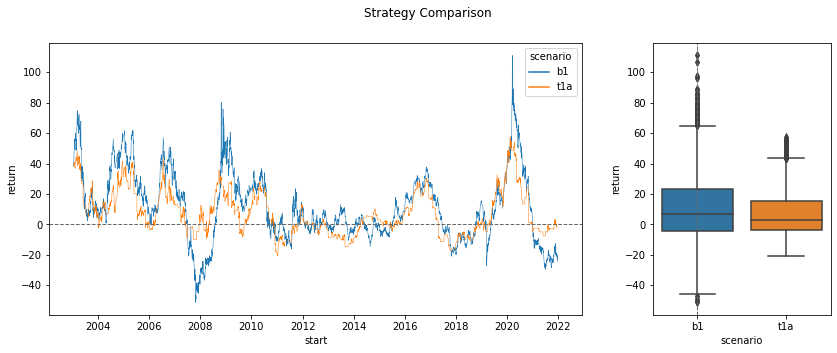

time: 1.7 s (started: 2023-02-28 17:59:23 +09:00)


In [348]:
ret_limit = None
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='return', x='scenario', ax=ax2, orient='v')

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

In [349]:
df = df.set_index(['scenario', 'start']).squeeze()

time: 17.6 ms (started: 2023-02-28 17:59:39 +09:00)


In [350]:
bayesian_estimate(df)

ERROR: df_returns is not series
time: 2.56 ms (started: 2023-02-28 17:59:40 +09:00)


In [351]:
df

index     return
scenario start                       
b1       2003-01-13      7  38.765165
         2003-01-15      9  39.031886
         2003-01-16     10  38.360915
         2003-01-17     11  41.648685
         2003-01-27     17  55.000665
...                    ...        ...
t1a      2021-12-23   3935  -2.055418
         2021-12-24   3936  -2.055418
         2021-12-27   3937  -2.055418
         2021-12-28   3938  -2.055418
         2021-12-29   3939  -2.055418

[8724 rows x 2 columns]

time: 53.4 ms (started: 2023-02-28 17:59:48 +09:00)
